In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [2]:
import os

imdb_dir='E:/Projects/Book_example/IMDB_sentiment_textsequence/aclImdb'
train_dir=os.path.join(imdb_dir,'train')

labels=[]
texts=[]


for label_type in ['neg','pos']:
    dir_name=os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)               


In [3]:


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen=100
training_samples=24000
validation_samples=1000
max_words=10000

tokenizer=Tokenizer(num_words=max_words)



tokenizer.fit_on_texts(texts)

word_index=tokenizer.word_index
print('Within the 25000 samples, found %s unique tokens.' %len(word_index))

sequences=tokenizer.texts_to_sequences(texts)
print('sequences is a list of list. It contain {} values, each value contain the integer index sequence of the review'.format(len(sequences)))
print('data is now in number sequence form')

data=pad_sequences(sequences,maxlen=maxlen)

print('data is 2D Numpy array, Shape of data tensor:',data.shape)
print('data is now in tensor form with maxlen')


labels=np.asarray(labels)

print('labels is now array tenosr with Shape of ',labels.shape)

Using TensorFlow backend.


Within the 25000 samples, found 88582 unique tokens.
sequences is a list of list. It contain 25000 values, each value contain the integer index sequence of the review
data is now in number sequence form
data is 2D Numpy array, Shape of data tensor: (25000, 100)
data is now in tensor form with maxlen
labels is now array tenosr with Shape of  (25000,)


In [6]:
idx=np.arange(data.shape[0])

print('indices is an array of size 25000, value from 0 to 24999 ', idx.shape)

np.random.shuffle(idx)

data=data[idx]


labels=labels[idx]

x_train=data[:training_samples]

print('x_train have shape ', x_train.shape)

y_train=labels[:training_samples]
print('y_train have shape ', y_train.shape)

x_val=data[training_samples: training_samples+validation_samples]
print('x_val have shape ', x_val.shape)

y_val=labels[training_samples:training_samples+validation_samples]
print('y_val have shape ', y_val.shape)

indices is an array of size 25000, value from 0 to 24999  (25000,)
x_train have shape  (24000, 100)
y_train have shape  (24000,)
x_val have shape  (1000, 100)
y_val have shape  (1000,)


In [7]:

glove_dir='E:/Projects/Book_example/IMDB_sentiment_textsequence/glove.6B'
embeddings_index={}
f=open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding="utf-8")

for line in f:  
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    #word vector values
    
    embeddings_index[word]=coefs
f.close()
print('embeddings_index is now a dict having key:value as the vocab: array tensor pair.Found %s word vectors.'%len(embeddings_index))



embeddings_index is now a dict having key:value as the vocab: array tensor pair.Found 400000 word vectors.


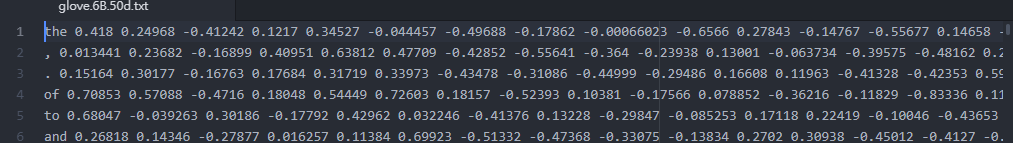

In [8]:
len(embeddings_index)

400000

In [9]:
embedding_dim=100
embedding_matrix=np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i<max_words:  
        embedding_vector=embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
            

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model= Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))

print('before the embedding layer the shape is',model.input_shape,'None is the batch dimension')
print('after the embedding layer the shape is now',model.output_shape,'None is the batch dimension')

model.add(Flatten())

model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()



Instructions for updating:
Colocations handled automatically by placer.
before the embedding layer the shape is (None, 100) None is the batch dimension
after the embedding layer the shape is now (None, 100, 100) None is the batch dimension
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
from keras import optimizers

model.layers[0].set_weights([embedding_matrix])


model.layers[0].trainable=False


model.summary()
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),loss='binary_crossentropy', metrics=['acc'])
history=model.fit(x_train,y_train,epochs=25,batch_size=32,validation_data=(x_val,y_val))

model.save_weights('pre_trained_glove_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 24000 samples, validate on 1000 samples
Epoch 1/25
24000/24000 [==============================] - 2s 104us/step - loss: 0.6908 - acc: 0.5455 - val_loss: 0.6773 - val_acc: 0.5690
Epoch 2/25
24000/24000 

In [12]:
model.layers[0].get_weights()

[array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
          0.27062 ],
        [-0.071953,  0.23127 ,  0.023731, ..., -0.71895 ,  0.86894 ,
          0.19539 ],
        ...,
        [ 0.13787 , -0.17727 , -0.62436 , ...,  0.35506 ,  0.33444 ,
          0.14436 ],
        [-0.88969 ,  0.55209 , -0.50499 , ..., -0.54351 , -0.21874 ,
          0.51186 ],
        [-0.17381 , -0.037609,  0.068837, ..., -0.097167,  1.0884  ,
          0.22676 ]], dtype=float32)]

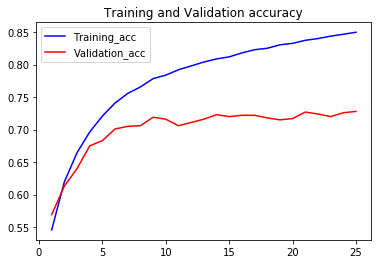

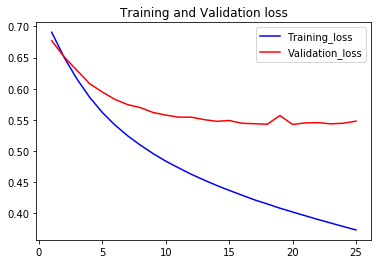

In [21]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='Training_acc')
plt.plot(epochs,val_acc,'r',label='Validation_acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'b',label='Training_loss')
plt.plot(epochs,val_loss,'r',label='Validation_loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
test_dir=os.path.join(imdb_dir,'test')

labels=[]
texts=[]


for label_type in ['neg','pos']:
    dir_name=os.path.join(test_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences=tokenizer.texts_to_sequences(texts)
x_test=pad_sequences(sequences,maxlen=maxlen)
y_test=np.array(labels)

In [15]:
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 1s 33us/step


[0.5361879183101654, 0.73484]

## test the result

In [26]:
test2=["I like this movie, it is very exciting! I enjoy watching this movie so much"]
sequences=tokenizer.texts_to_sequences(test2)
x_test2=pad_sequences(sequences,maxlen=maxlen)
x_test2.shape

(1, 100)

In [27]:
model.predict(x_test2)

array([[0.79366624]], dtype=float32)

In [28]:
model.predict_classes(x_test2)

array([[1]])

- label type index 1 = 'positive'